In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [7]:
#Loading the dataset
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv")
cols = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']
df = df[cols]
df.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


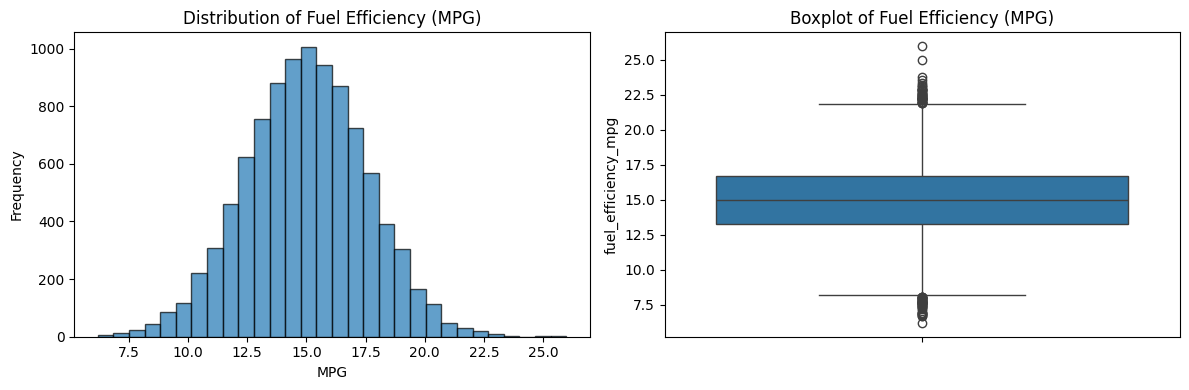

Fuel Efficiency Statistics:
count    9704.000000
mean       14.985243
std         2.556468
min         6.200971
25%        13.267459
50%        15.006037
75%        16.707965
max        25.967222
Name: fuel_efficiency_mpg, dtype: float64


In [8]:
# EDA: Look at fuel_efficiency_mpg distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['fuel_efficiency_mpg'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Fuel Efficiency (MPG)')
plt.xlabel('MPG')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['fuel_efficiency_mpg'])
plt.title('Boxplot of Fuel Efficiency (MPG)')

plt.tight_layout()
plt.show()

print("Fuel Efficiency Statistics:")
print(df['fuel_efficiency_mpg'].describe())

In [3]:
# check missing values
print("Missing values per column")
print(df.isnull().sum())

Missing values per column
engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64


In [4]:
# 2. Median for horsepower

print(df['horsepower'].median())

149.0


In [13]:
# Filter to only use the specified columns
df_filtered = df.copy()

# Shuffle the dataset with seed 42
df_shuffled = df_filtered.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data (60% train, 20% validation, 20% test)
train_size = 0.6
val_size = 0.2
test_size = 0.2

# First split: separate train from temp (val + test)
train_df, temp_df = train_test_split(df_shuffled, test_size=(val_size + test_size), random_state=42)

# Second split: separate val from test
val_df, test_df = train_test_split(temp_df, test_size=test_size/(val_size + test_size), random_state=42)

print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")



Train set size: 5822
Validation set size: 1941
Test set size: 1941


In [14]:
# Prepare features and target
def prepare_features(df, fill_value=None, train_mean=None):
    X = df[['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']].copy()
    y = df['fuel_efficiency_mpg'].values
    
    # Handle missing values
    if fill_value == 'mean' and train_mean is not None:
        X['horsepower'] = X['horsepower'].fillna(train_mean)
    else:
        X['horsepower'] = X['horsepower'].fillna(0)
    
    return X.values, y

# Calculate mean horsepower from training data for the mean filling approach
train_horsepower_mean = train_df['horsepower'].mean()

# Prepare datasets for both approaches
X_train_zero, y_train = prepare_features(train_df, fill_value='zero')
X_val_zero, y_val = prepare_features(val_df, fill_value='zero')

X_train_mean, _ = prepare_features(train_df, fill_value='mean', train_mean=train_horsepower_mean)
X_val_mean, _ = prepare_features(val_df, fill_value='mean', train_mean=train_horsepower_mean)

# Train models and evaluate
model_zero = LinearRegression()
model_zero.fit(X_train_zero, y_train)

model_mean = LinearRegression()
model_mean.fit(X_train_mean, y_train)

# Make predictions
y_pred_zero = model_zero.predict(X_val_zero)
y_pred_mean = model_mean.predict(X_val_mean)

# Calculate RMSE
rmse_zero = np.sqrt(mean_squared_error(y_val, y_pred_zero))
rmse_mean = np.sqrt(mean_squared_error(y_val, y_pred_mean))

print(f"RMSE with 0 filling: {round(rmse_zero, 2)}")
print(f"RMSE with mean filling: {round(rmse_mean, 2)}")

RMSE with 0 filling: 0.51
RMSE with mean filling: 0.46


In [15]:
# Try different regularization values
r_values = [0, 0.01, 0.1, 1, 5, 10, 100]
rmse_scores = []

for r in r_values:
    model = Ridge(alpha=r)
    model.fit(X_train_zero, y_train)
    y_pred = model.predict(X_val_zero)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores.append(rmse)
    print(f"r={r}: RMSE = {round(rmse, 2)}")

# Find the best r
best_idx = np.argmin(rmse_scores)
best_r = r_values[best_idx]
print(f"\nBest r value: {best_r}")

r=0: RMSE = 0.51
r=0.01: RMSE = 0.51
r=0.1: RMSE = 0.51
r=1: RMSE = 0.51
r=5: RMSE = 0.51
r=10: RMSE = 0.51
r=100: RMSE = 0.51

Best r value: 100


In [16]:
# Check stability with different seeds
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rmse_scores_seeds = []

for seed in seeds:
    # Split data with current seed
    df_shuffled_seed = df_filtered.sample(frac=1, random_state=seed).reset_index(drop=True)
    train_df_seed, temp_df_seed = train_test_split(df_shuffled_seed, test_size=0.4, random_state=seed)
    val_df_seed, test_df_seed = train_test_split(temp_df_seed, test_size=0.5, random_state=seed)
    
    # Prepare features (fill with 0)
    X_train_seed, y_train_seed = prepare_features(train_df_seed, fill_value='zero')
    X_val_seed, y_val_seed = prepare_features(val_df_seed, fill_value='zero')
    
    # Train model and evaluate
    model_seed = LinearRegression()
    model_seed.fit(X_train_seed, y_train_seed)
    y_pred_seed = model_seed.predict(X_val_seed)
    rmse_seed = np.sqrt(mean_squared_error(y_val_seed, y_pred_seed))
    rmse_scores_seeds.append(rmse_seed)
    print(f"Seed {seed}: RMSE = {round(rmse_seed, 3)}")

# Calculate standard deviation
std_rmse = np.std(rmse_scores_seeds)
print(f"\nStandard deviation of RMSE scores: {round(std_rmse, 3)}")

Seed 0: RMSE = 0.518
Seed 1: RMSE = 0.509
Seed 2: RMSE = 0.514
Seed 3: RMSE = 0.515
Seed 4: RMSE = 0.518
Seed 5: RMSE = 0.524
Seed 6: RMSE = 0.515
Seed 7: RMSE = 0.525
Seed 8: RMSE = 0.508
Seed 9: RMSE = 0.529

Standard deviation of RMSE scores: 0.007


In [17]:
# Split with seed 9 and combine train + validation
df_shuffled_9 = df_filtered.sample(frac=1, random_state=9).reset_index(drop=True)
train_val_df, test_df_final = train_test_split(df_shuffled_9, test_size=0.2, random_state=9)
train_df_final, val_df_final = train_test_split(train_val_df, test_size=0.25, random_state=9)  # 0.25 of 0.8 = 0.2

# Combine train and validation
combined_train_df = pd.concat([train_df_final, val_df_final])

# Prepare features for combined training and test sets
X_combined, y_combined = prepare_features(combined_train_df, fill_value='zero')
X_test_final, y_test_final = prepare_features(test_df_final, fill_value='zero')

# Train model with r=0.001
model_final = Ridge(alpha=0.001)
model_final.fit(X_combined, y_combined)

# Evaluate on test set
y_pred_final = model_final.predict(X_test_final)
rmse_final = np.sqrt(mean_squared_error(y_test_final, y_pred_final))

print(f"Final RMSE on test set: {round(rmse_final, 3)}")

Final RMSE on test set: 0.537
